In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


## `Airbnb Application`

Airbnb, headquartered in San Francisco, operates a global online marketplace and hospitality service accessible via its websites and mobile apps. 

Airbnb is an online marketplace which lets people rent out their properties or spare rooms to guests. Airbnb takes 3% commission of every booking from hosts, and between 6% and 12% from guests.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience. 

Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.


## `Frame the problem`

Target is to predict which country a new user's first booking destination will be.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. 

Here will demonstrate the entire process to suggest the first destination of new Airbnb Users. All the processes involved, such as data wrangling, exploratory data analysis, inferential statistics and machine learning.


## `Import Needed Libraries`

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import mode
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import plotly.graph_objects as go
import plotly.express as px
import requests
from bs4 import BeautifulSoup
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost.sklearn import XGBClassifier
import catboost as cgb
import xgboost as xgb
import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, make_scorer, ndcg_score
from sklearn.decomposition import PCA
from scipy.stats import skew
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import re
import gc
import os
import itertools
import math
plt.style.use("seaborn-whitegrid")
sns.set_context("talk")
warnings.filterwarnings('ignore')

## `Load Data`

In [3]:
#Loading the Data
df_train = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_test = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

In [4]:
df_train.sample(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
181062,k2uhjk3vpi,2014-04-27,20140427045440,NaN,FEMALE,23.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Chrome,NDF
144443,6e00sqeid8,2014-01-21,20140121200014,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
128760,e5bled0mim,2013-12-01,20131201073259,2013-12-06,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,other
19702,tt3cgtgx4r,2012-03-25,20120325053146,NaN,MALE,67.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,NDF
130620,38w7qgvjua,2013-12-07,20131207203552,NaN,MALE,42.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
151855,4r9hkhnbv2,2014-02-11,20140211211144,2014-02-11,FEMALE,28.0,basic,0,en,direct,direct,product,Web,Mac Desktop,Safari,FR
78318,7t5z6yugx0,2013-05-20,20130520230159,NaN,MALE,36.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,NDF
170234,vhu9qnylnh,2014-04-01,20140401042103,NaN,-unknown-,NaN,basic,0,en,direct,direct,product,Web,Mac Desktop,Safari,NDF
11739,e2hemmuebi,2011-10-27,20111027050441,2011-10-29,FEMALE,46.0,basic,2,en,other,other,omg,Web,Mac Desktop,Safari,US
15485,s9r7wy34oa,2012-01-19,20120119013323,NaN,FEMALE,54.0,facebook,3,en,other,other,tracked-other,Web,Mac Desktop,Safari,NDF


In [5]:
df_age = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip')
df_age.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [6]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [7]:
df_sessions = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [8]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [9]:
df_countries = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/countries.csv.zip')
df_countries.head(20)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [10]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


## `Exploratory Data Analysis`

In [11]:
df_train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [13]:
#Finding the number of null entries in each column.
for column in df_train.columns:
    nulls = df_train[column].isnull().sum()
    if nulls != 0:
        print("Null Values of ",colored(column, 'green'),"are: ", colored(nulls, 'red'))

Null Values of  date_first_booking are:  124543
Null Values of  age are:  87990
Null Values of  first_affiliate_tracked are:  6065


In [14]:
# Converting dtype of target from object to categorical for label encoding
df_train.country_destination = df_train.country_destination.astype('category')
df_train['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [15]:
df_train.country_destination.mode()

0    NDF
Name: country_destination, dtype: category
Categories (12, object): ['AU', 'CA', 'DE', 'ES', ..., 'NL', 'PT', 'US', 'other']

In [16]:
#Converting below columns as categories for plotting in graphs
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_train[categorical_feature] = df_train[categorical_feature].astype('category')

## `Data Visualization`

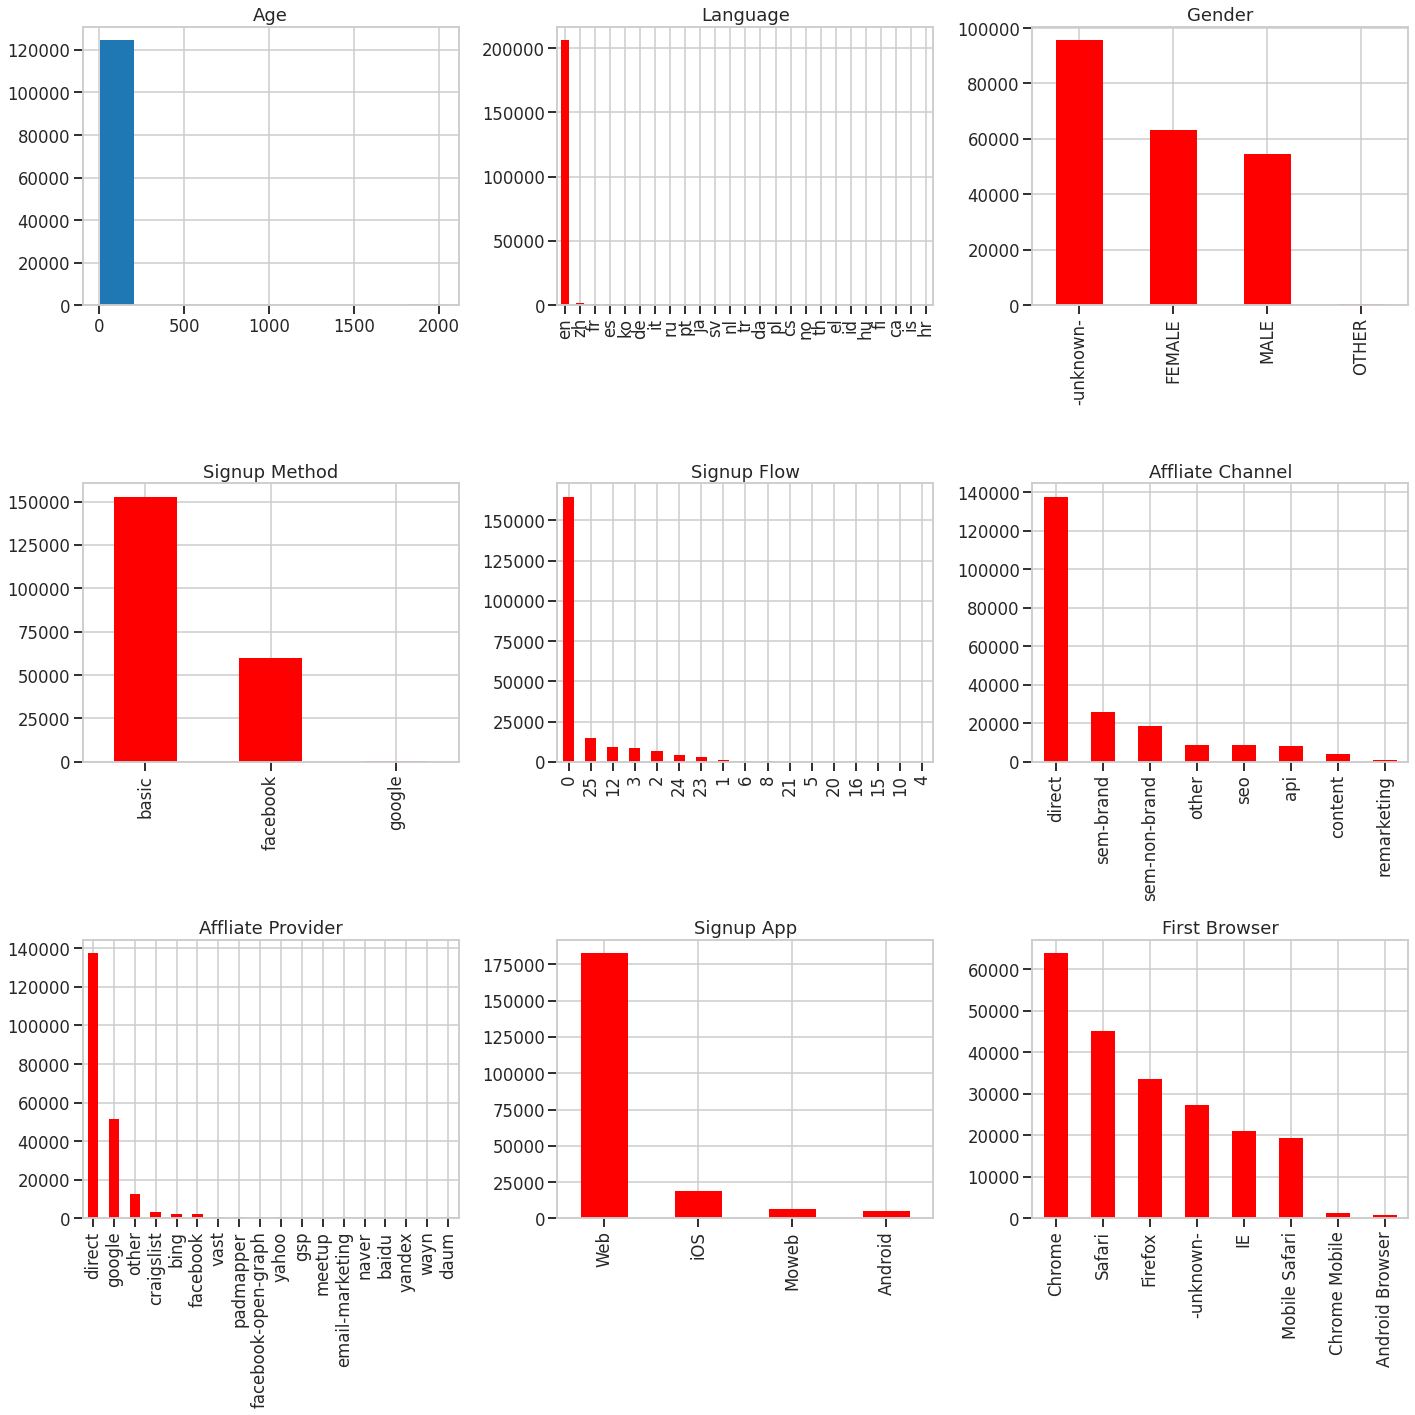

In [17]:
#features
df=df_train.copy()
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# row one
ax[0,0].set_title('Age')
df['age'].hist(ax=ax[0,0])

ax[0,1].set_title('Language')
df['language'].value_counts().plot.bar(ax=ax[0,1], color='red')

ax[0,2].set_title('Gender')
df['gender'].value_counts().plot.bar(ax=ax[0,2], color='red')

# row two
ax[1,0].set_title('Signup Method')
df['signup_method'].value_counts().plot.bar(ax=ax[1,0], color='red')

ax[1,1].set_title('Signup Flow')
df['signup_flow'].value_counts().plot.bar(ax=ax[1,1], color='red')

ax[1,2].set_title('Affliate Channel')
df['affiliate_channel'].value_counts().plot.bar(ax=ax[1,2], color='red')

# row three
ax[2,0].set_title('Affliate Provider')
df['affiliate_provider'].value_counts().plot.bar(ax=ax[2,0], color='red')

ax[2,1].set_title('Signup App')
df['signup_app'].value_counts().plot.bar(ax=ax[2,1], color='red')

ax[2,2].set_title('First Browser')
df['first_browser'].value_counts().nlargest(8).plot.bar(ax=ax[2,2], color='red')

plt.tight_layout()

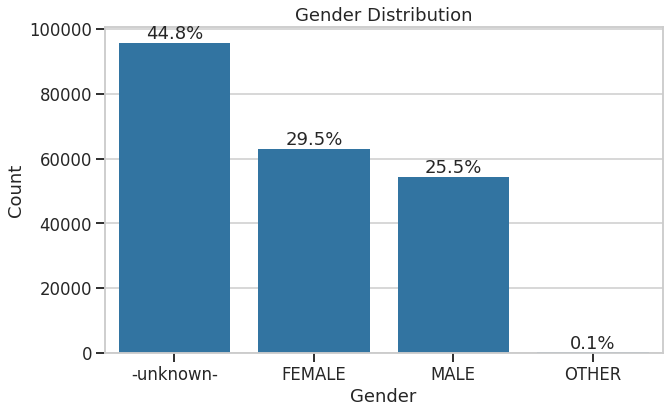

In [18]:
#Finding the gender distribution
df=df_train.copy()

plt.figure(figsize=(10,6))
order1 = df['gender'].value_counts().index
sns.countplot(data = df, x = 'gender', order = order1, color = sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df.shape[0])
    plt.text(i,count+1000,strt,ha='center')

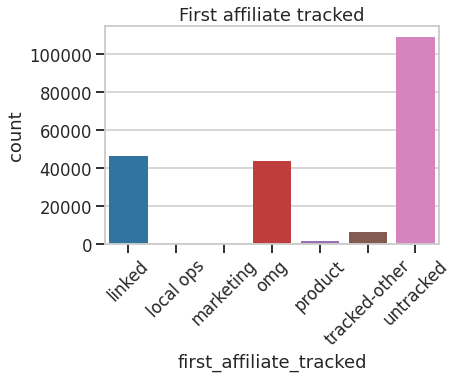

In [19]:
sns.countplot(df_train.first_affiliate_tracked)
plt.title('First affiliate tracked')
plt.xticks(rotation=45)
plt.show()

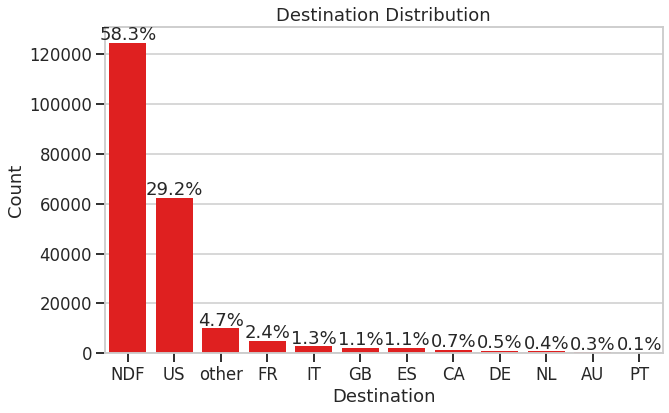

In [20]:
#Finding Destination Distribution.

plt.figure(figsize=(10,6))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = 'red')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

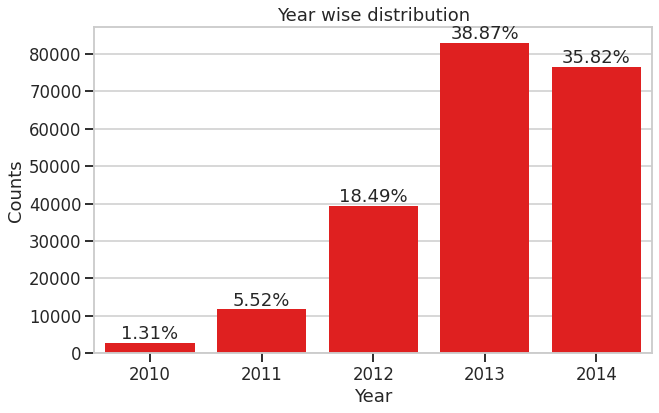

In [21]:
#Extracting year for date_account_created
df = df_train.copy()
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')
df['acc_year'] = df['date_account_created'].dt.year
df1 = df.groupby('acc_year').count()
df1.head()

years = [2010,2011,2012,2013,2014]
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace = True)
df1.acc_year = df1.acc_year.astype(yearsOrder)

#Finding year-wise distribution

plt.figure(figsize=[10,6])
sns.barplot(data=df1,x='acc_year',y='affiliate_provider',color='red');
plt.title('Year wise distribution');
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df.shape[0])
    plt.text(i,count+1000,strt,ha='center')


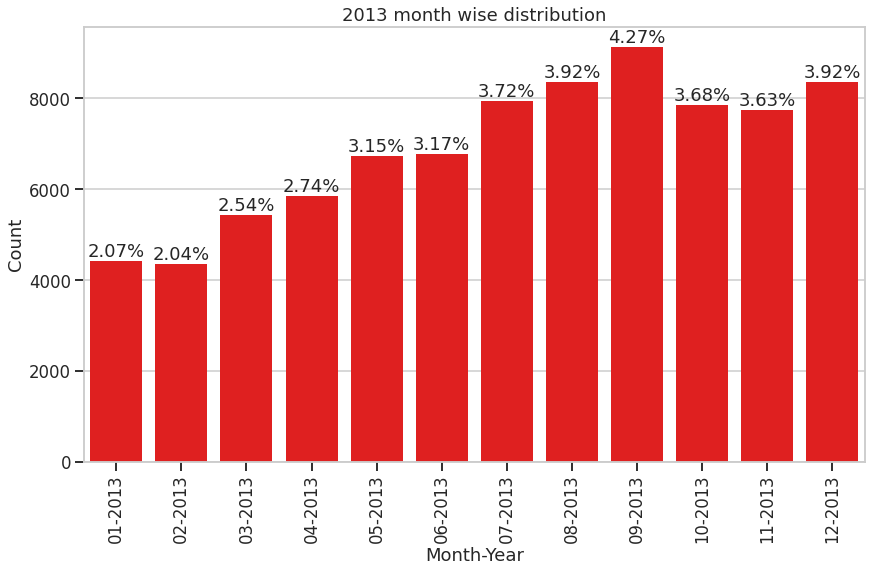

In [22]:
# Creating a month centered dataframe for 2014
df = df_train.copy()
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'])#, format='%Y%m%d%H%M%S')
df3 = df[df['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df3 = df3.groupby('monthYear13').count()

#Number of accounts created in different month of 2014

# classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
#     ctab = pd.crosstab([df[feature].fillna('Unknown')], df.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
#     ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False) 
    
    
plt.figure(figsize=[14,8])
sns.barplot(data=df3,x=df3.index,y='country_destination',color='red');
plt.title('2013 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=90)
for i in range(df3.shape[0]):
    count=df3.iloc[i]['country_destination']
    strt='{:0.2f}%'.format(100*count/df.shape[0])
    plt.text(i,count+100,strt,ha='center')

In [23]:
fig = px.treemap(df_age, path=['country_destination','gender','age_bucket'], values='population_in_thousands',
                title='Distribution by country, gender & age')
fig.show()

In [24]:
lang = df_train.groupby(['language','country_destination']).id.count().reset_index()
plt.figure(figsize=(10,8))
# fig = sns.heatmap(lang.pivot_table(values='id',index='language',columns='country_destination',aggfunc='sum'), cmap='Reds')
# plt.text(0, -2,"Where do they go for their 1st trip of different countries?", family='sans-serif', fontsize=15, weight='bold')

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [25]:
lang = lang.rename(columns={'id':'count'})
# px.pie(df_train.groupby('language').id.count().sort_values(ascending=False).reset_index(), values='id', names='language')

In [26]:
lang_with_booking = lang[lang['country_destination']!='NDF']
fig = px.bar(lang_with_booking, x="language", y="count", color="country_destination", title="Where do differnt language speaker usually go?")
fig.show()

In [27]:
lang_with_booking_exclude_us = lang_with_booking[lang_with_booking['language']!='en']
fig = px.bar(lang_with_booking_exclude_us, x="language", y="count", color="country_destination", title="Where do non-english language speaker usually go?")
fig.show()

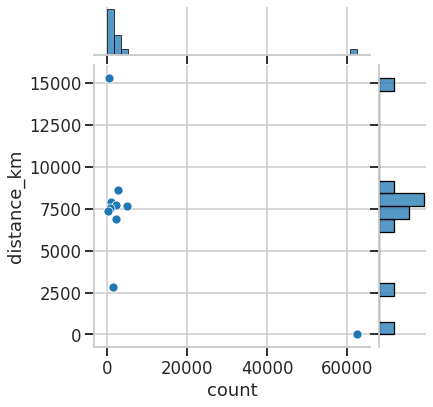

In [28]:
# df = df_train.copy()
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

country_distance = pd.Series(df_countries['distance_km'])
country_distance.index = df_countries['country_destination']

language_distance = pd.Series(df_countries['language_levenshtein_distance'])
language_distance.index = df_countries['country_destination']

country_area = pd.Series(df_countries['destination_km2'])
country_area.index = df_countries['country_destination']

df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']

sns.jointplot(x='count', y='distance_km', data=df_dp)

There is a strong negative correlation of -0.65. People overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

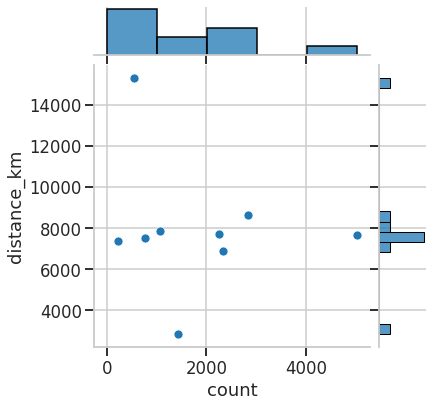

In [29]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))


The correlation, with United States out of the equation, is much lower at -0.18. However, there is still a negative correlation between the two quantities.

Next, let us check if the language spoken in a particular country influences the number of bookings in that country. To calculate this metric, we will use the Language Levenshtein Distance of each country's official language from English. This data is already made available to us by Airbnb. Again, like physical distance, my guess is that lower the levenshtein distance, greater the number of bookings in that country.

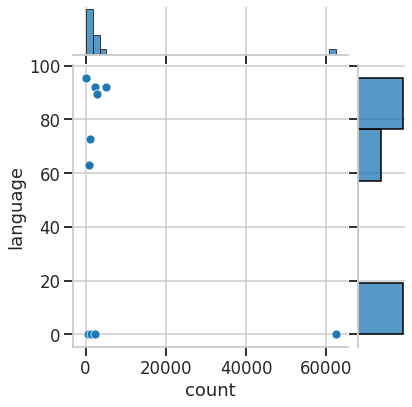

In [30]:
sns.jointplot(x='count', y='language', data=df_dp)

There seems to be a medium negative correlation of -0.38 between the two quantities. This suggests that people indeed prefer countries that speak English. But is that really the case? Let us remove United States, the home country, once again and recalculate our correlation coefficient.

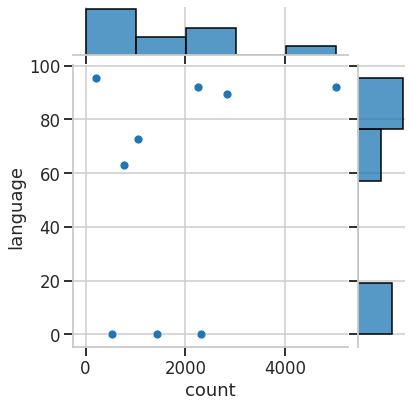

In [31]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

The result of this visualisation is extremely interesting.

We see that when United States is removed from the list of countries, there is actually a positive correlation between language distance and booking frequency.
At first glance, this may suggest that people prefer countries with different language (and therefore culture) while travelling abroad.
Another way of looking at it would be that Europe is an extremely popular travel destination for Americans and they tend to prefer it to other English Speaking countries like Canada and Australia. So this may have nothing to do with language difference as it may have to do with destination preference.
Finally, in this section, let us check if the size of the country has anything to do with booking preference. Like the previous two cases, we have data on the size of each country.

In [32]:
# Stacked Bar

classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

<AxesSubplot:xlabel='affiliate_channel', ylabel='count'>

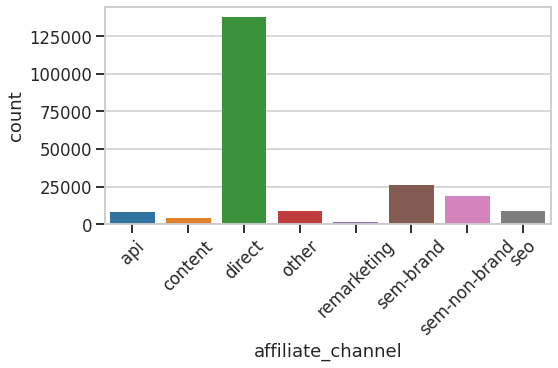

In [33]:
plt.figure(figsize=(8,4))
plt.xticks(rotation=45)
sns.countplot(df_train['affiliate_channel'])

<AxesSubplot:xlabel='affiliate_provider', ylabel='count'>

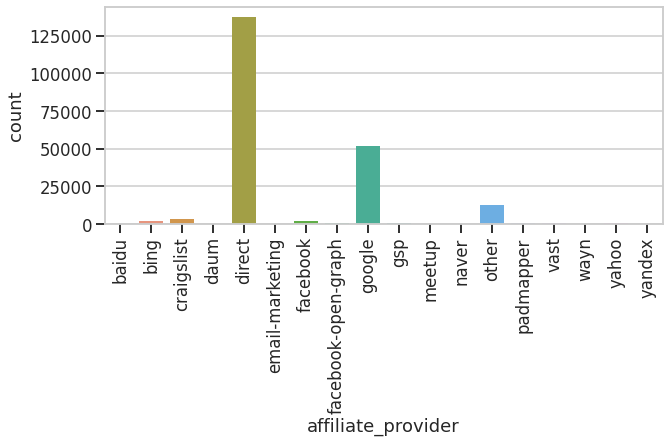

In [34]:
plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
sns.countplot(df_train['affiliate_provider'])

## `Feature Engineering and PreProcessing`

In [35]:
# merge train and test users to get insights

df_all = pd.concat([df_train, df_test], axis=0)
train_id = df_train.id
test_id = df_test.id
all_id = df_all.id

In [36]:
df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [37]:
df_train["country_destination"].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [38]:
#date account create
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"])#, format = "%Y-%m-%d")

#timestamp first active
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"])#, format="%Y%m%d%H%M%S")

<AxesSubplot:>

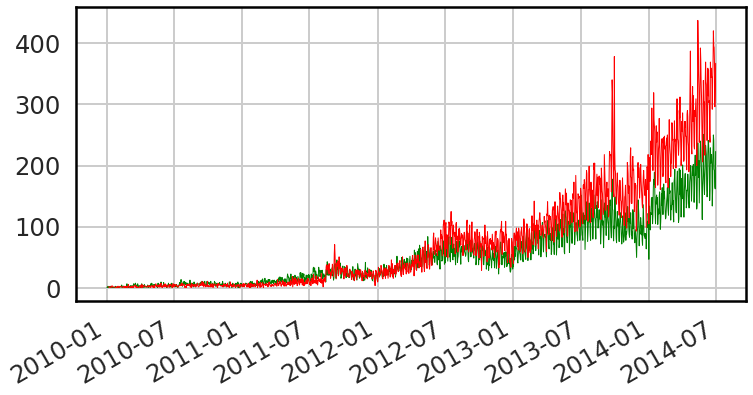

In [39]:
df = df_train.copy()
df['date_account_created'] = pd.to_datetime(df['date_account_created'])

sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df[df['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df[df['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

In [40]:
df_all['create_year'] = df_all["date_account_created"].apply(lambda x : x.year)
df_all['create_month'] = df_all["date_account_created"].apply(lambda x : x.month)
df_all['create_day'] = df_all["date_account_created"].apply(lambda x : x.day)

df_all['active_year'] = df_all["timestamp_first_active"].apply(lambda x : x.year)
df_all['active_month'] = df_all["timestamp_first_active"].apply(lambda x : x.month)
df_all['active_day'] = df_all["timestamp_first_active"].apply(lambda x : x.day)

df_all.shape

(275547, 22)

In [41]:
df_all.sample(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,create_year,create_month,create_day,active_year,active_month,active_day
186501,pjxfr1eszb,2014-05-08,1970-01-01 05:35:40.508233804,NaN,-unknown-,NaN,basic,0,en,seo,...,Web,Mac Desktop,Chrome,NDF,2014,5,8,1970,1,1
91041,7ttjswwu62,2013-07-14,1970-01-01 05:35:30.714212521,2013-07-18,FEMALE,28.0,facebook,0,en,direct,...,Web,Mac Desktop,Safari,US,2013,7,14,1970,1,1
125318,v43pk8738v,2013-11-17,1970-01-01 05:35:31.117200859,2014-08-27,FEMALE,34.0,basic,24,en,direct,...,Moweb,Other/Unknown,-unknown-,US,2013,11,17,1970,1,1
53757,d54oe37dl1,2014-09-17,1970-01-01 05:35:40.917053646,NaN,-unknown-,NaN,basic,0,en,direct,...,Web,Mac Desktop,Safari,NaN,2014,9,17,1970,1,1
132350,w6k71fn63w,2013-12-14,1970-01-01 05:35:31.214013424,2014-01-07,FEMALE,28.0,facebook,0,en,direct,...,Web,iPhone,Mobile Safari,US,2013,12,14,1970,1,1


In [42]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

def stacked_bar(feature):
#     plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ctab = pd.crosstab([df_all[feature]], df_all.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False, figsize=(12,6), )

In [43]:
df_all.create_month.value_counts(normalize=True)

8     0.131509
7     0.128936
9     0.124004
6     0.099518
5     0.094038
4     0.079359
3     0.073762
1     0.063492
2     0.060178
10    0.048906
12    0.048649
11    0.047647
Name: create_month, dtype: float64

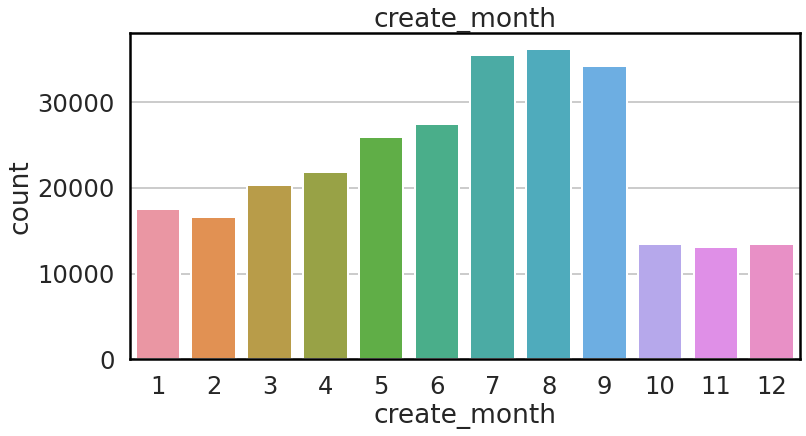

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(df_all[df_all.create_month.notnull()].create_month)
plt.title('create_month')
plt.show()

### `Lagging time`
### Helps to identify patterns within the time series technique,the tendency for patterns to repeat at periodic frequencies.

In [45]:

print("date_account_created",df_all['date_account_created'].isnull().sum()*100/len(df_all['date_account_created']))
print("timestamp_first_active",df_all['timestamp_first_active'].isnull().sum()*100/len(df_all['timestamp_first_active']))
print("date_first_booking",df_all['date_first_booking'].isnull().sum()*100/len(df_all['date_first_booking']))

date_account_created 0.0
timestamp_first_active 0.0
date_first_booking 67.73399819268582


In [46]:
lagging = df_all["timestamp_first_active"] - df_all["date_account_created"]

#lagging time days, log seconds
df_all["lag_days"] = lagging.apply(lambda x : -1 * x.days)
df_all["lag_seconds"] = np.log(lagging.apply(lambda x : x.seconds))

df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_browser,country_destination,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds
0,gxn3p5htnn,2010-06-28,1970-01-01 05:34:50.319043255,NaN,-unknown-,NaN,facebook,0,en,direct,...,Chrome,NDF,2010,6,28,1970,1,1,14788,9.907977
1,820tgsjxq7,2011-05-25,1970-01-01 05:34:50.523174809,NaN,MALE,38.0,facebook,0,en,seo,...,Chrome,NDF,2011,5,25,1970,1,1,15119,9.907977
2,4ft3gnwmtx,2010-09-28,1970-01-01 05:34:50.609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,IE,US,2010,9,28,1970,1,1,14880,9.907977
3,bjjt8pjhuk,2011-12-05,1970-01-01 05:34:51.031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,Firefox,other,2011,12,5,1970,1,1,15313,9.908027
4,87mebub9p4,2010-09-14,1970-01-01 05:34:51.208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,Chrome,US,2010,9,14,1970,1,1,14866,9.908027


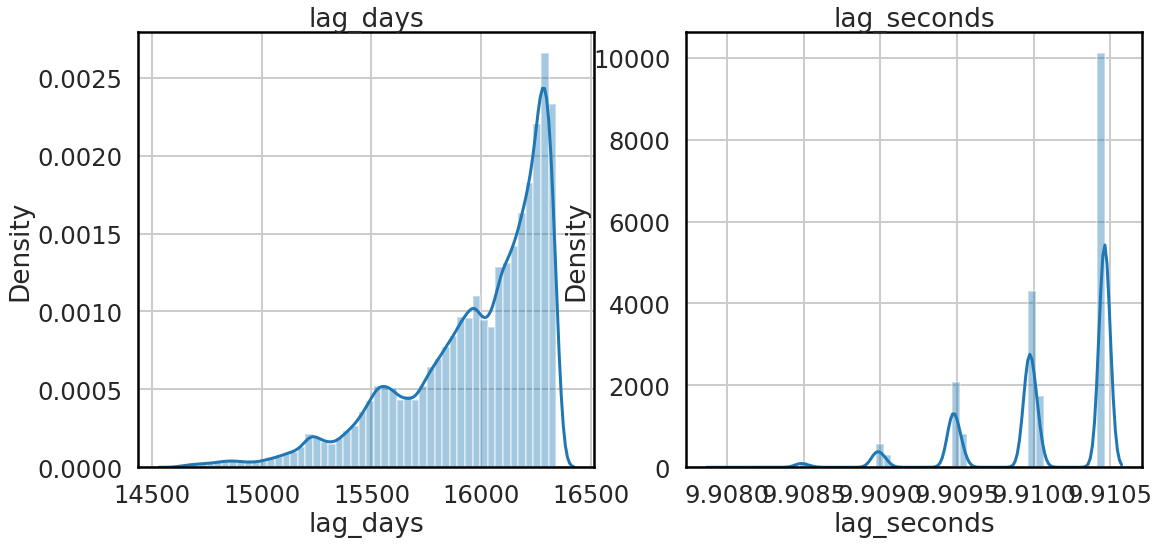

In [47]:
# plotting lag columns 
fig, ax =plt.subplots(1,2, figsize=(18, 8))
sns.distplot(df_all[df_all.lag_days.notnull()].lag_days, ax=ax[0])
ax[0].set_title('lag_days')
sns.distplot(df_all[df_all.lag_seconds.notnull()].lag_seconds, ax=ax[1])
ax[1].set_title('lag_seconds')
fig.show()

In [48]:
df_all.country_destination.shape, df_all.lag_seconds.shape

((275547,), (275547,))

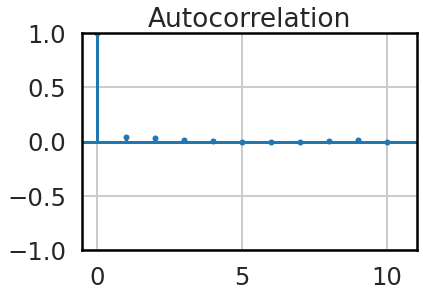

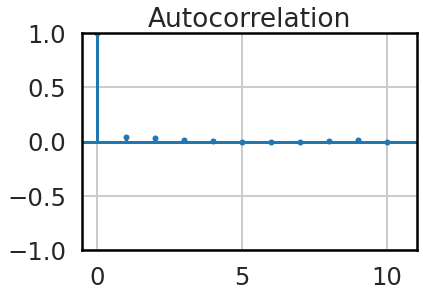

In [49]:
df2 = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df2["date_account_created"] = pd.to_datetime(df2["date_account_created"], format = "%Y-%m-%d")
df2["timestamp_first_active"] = pd.to_datetime(df2["timestamp_first_active"], format="%Y%m%d%H%M%S")

lagging = df2["timestamp_first_active"] - df2["date_account_created"]

#lagging time days, log seconds
df2["lag_days"] = lagging.apply(lambda x : -1 * x.days)
df2["lag_seconds"] = np.log(lagging.apply(lambda x : x.seconds))

plot_acf(df2["lag_days"], lags=10)

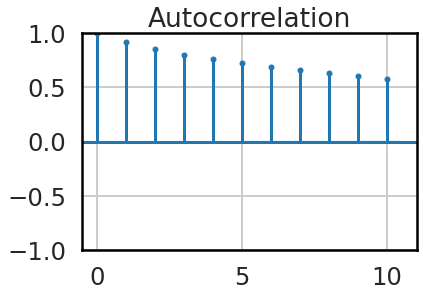

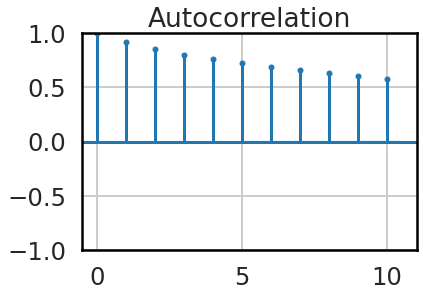

In [50]:
#see the auto correlation to ensure the importance of this feature with target

plot_acf(df2["lag_seconds"], lags=10)

### `Add Holiday Feature`

In [51]:
# web scrape to parse holidays data 

def get_holidays(year):
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"                                &country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")
    trs = dom.select("table.cht.lpad tr")
    
    df = pd.DataFrame(columns=["date", "holiday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1}
    return df

holiday_ls = []
for year in range(2009, 2015):
    df = get_holidays(year)
    holiday_ls.append(df)
    holiday_df = pd.concat(holiday_ls)
select_date = list(holiday_df["date"].astype("str"))
holiday = df_all.timestamp_first_active.apply(lambda x : str(x.date())).isin(select_date)

df_all["holiday"] = holiday
df_all['holiday'] = 1 * (df_all.holiday == True)

df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,country_destination,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday
0,gxn3p5htnn,2010-06-28,1970-01-01 05:34:50.319043255,NaN,-unknown-,NaN,facebook,0,en,direct,...,NDF,2010,6,28,1970,1,1,14788,9.907977,0
1,820tgsjxq7,2011-05-25,1970-01-01 05:34:50.523174809,NaN,MALE,38.0,facebook,0,en,seo,...,NDF,2011,5,25,1970,1,1,15119,9.907977,0
2,4ft3gnwmtx,2010-09-28,1970-01-01 05:34:50.609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,US,2010,9,28,1970,1,1,14880,9.907977,0
3,bjjt8pjhuk,2011-12-05,1970-01-01 05:34:51.031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,other,2011,12,5,1970,1,1,15313,9.908027,0
4,87mebub9p4,2010-09-14,1970-01-01 05:34:51.208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,US,2010,9,14,1970,1,1,14866,9.908027,0


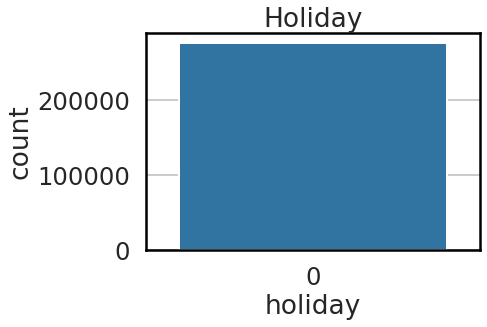

In [52]:
# plt.hist(df_all.holiday)
# plt.title('Holiday')
# plt.show()
sns.countplot(df_all[df_all.holiday.notnull()].holiday)
plt.title('Holiday')
plt.show()

### `Add weekend`

In [53]:
weekday = df_all.filter(items=['id','timestamp_first_active'])
weekday = pd.to_datetime(weekday["timestamp_first_active"], format="%Y-%m-%d")
weekday = weekday.dt.dayofweek

df_all["weekend"] = weekday.apply(lambda x : 1 if x>=5 else 0)

df_all.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend
0,gxn3p5htnn,2010-06-28,1970-01-01 05:34:50.319043255,NaN,-unknown-,NaN,facebook,0,en,direct,...,2010,6,28,1970,1,1,14788,9.907977,0,0
1,820tgsjxq7,2011-05-25,1970-01-01 05:34:50.523174809,NaN,MALE,38.0,facebook,0,en,seo,...,2011,5,25,1970,1,1,15119,9.907977,0,0
2,4ft3gnwmtx,2010-09-28,1970-01-01 05:34:50.609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,2010,9,28,1970,1,1,14880,9.907977,0,0
3,bjjt8pjhuk,2011-12-05,1970-01-01 05:34:51.031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,2011,12,5,1970,1,1,15313,9.908027,0,0
4,87mebub9p4,2010-09-14,1970-01-01 05:34:51.208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,2010,9,14,1970,1,1,14866,9.908027,0,0


In [54]:
# so no need for "timestamp_first_active" and "date_account_created" columns any more.
df_all = df_all.drop("date_account_created" , axis=1)
df_all = df_all.drop("timestamp_first_active" , axis=1)

df_all.sample(5)

,id,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend
81952,hisnxunyca,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,...,2013,6,5,1970,1,1,15861,9.909967,0,0
60802,m7kusuu5kp,2013-02-17,-unknown-,NaN,basic,0,en,direct,direct,untracked,...,2013,2,16,1970,1,1,15752,9.909967,0,0
213173,0l8gxgzwz9,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,...,2014,6,30,1970,1,1,16251,9.910463,0,0
96835,cvkcd78i21,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,...,2013,8,6,1970,1,1,15923,9.909967,0,0
41626,ens13eae5e,NaN,FEMALE,NaN,basic,0,en,direct,direct,omg,...,2012,9,19,1970,1,1,15602,9.909470,0,0


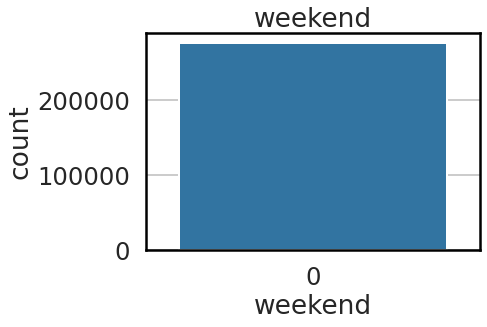

In [55]:
# df_all.weekend.hist()

sns.countplot(df_all[df_all.weekend.notnull()].weekend)
plt.title('weekend')
plt.show()

### `Booked Feature`

In [56]:
df_all.country_destination.value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [57]:
# df_all["booked"] = df_all.country_destination.apply(lambda x : 0 if x=='NDF' else 1)


In [58]:
# sns.countplot(df_all[df_all.booked.notnull()].booked)
# plt.title('Booked or Not')
# plt.show()

### `faithless sign-in`

In [59]:
## users with false data 

checklist = (df_all['age'] < 100) & (df_all['gender'] != '-unknown-')

df_all['faithless_sign'] = checklist.apply(lambda x : 0 if x == True else 1)
df_all.head()

,id,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend,faithless_sign
0,gxn3p5htnn,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,...,6,28,1970,1,1,14788,9.907977,0,0,1
1,820tgsjxq7,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,...,5,25,1970,1,1,15119,9.907977,0,0,0
2,4ft3gnwmtx,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,...,9,28,1970,1,1,14880,9.907977,0,0,0
3,bjjt8pjhuk,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,...,12,5,1970,1,1,15313,9.908027,0,0,0
4,87mebub9p4,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,...,9,14,1970,1,1,14866,9.908027,0,0,1


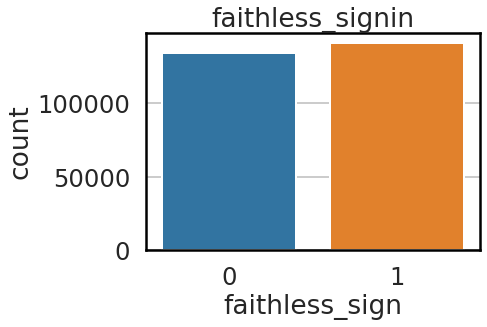

In [60]:
sns.countplot(df_all[df_all.faithless_sign.notnull()].faithless_sign)
plt.title('faithless_signin')
plt.show()

In [61]:
# plt.figure(figsize=(12,8))
# sns.barplot(x='country_destination', y='booked',  data=df_all, ci=None)

In [62]:
# plt.figure(figsize=(12,8))
# sns.barplot(x='country_destination', y='faithless_sign',  data=df_all, ci=None)

### `First Browser`

In [63]:
df_all.first_browser.value_counts(normalize=True)

Chrome                  0.285508
Safari                  0.193441
-unknown-               0.161112
Firefox                 0.140321
Mobile Safari           0.107553
IE                      0.089800
Chrome Mobile           0.011562
Android Browser         0.005723
AOL Explorer            0.000922
Opera                   0.000827
Silk                    0.000624
IE Mobile               0.000428
BlackBerry Browser      0.000323
Chromium                0.000301
Mobile Firefox          0.000232
Maxthon                 0.000218
Apple Mail              0.000163
Sogou Explorer          0.000156
SiteKiosk               0.000098
Iron                    0.000087
RockMelt                0.000087
IceWeasel               0.000051
Yandex.Browser          0.000051
Pale Moon               0.000047
SeaMonkey               0.000044
CometBird               0.000044
Camino                  0.000033
TenFourFox              0.000029
Opera Mini              0.000029
wOSBrowser              0.000025
CoolNovo  

In [64]:
# replace _unknown_ with nulls
df_all['first_browser'] = df_all['first_browser'].replace('-unknown-', np.nan)
df_all.first_browser.value_counts(normalize=True)

Chrome                  0.340342
Safari                  0.230592
Firefox                 0.167270
Mobile Safari           0.128209
IE                      0.107046
Chrome Mobile           0.013783
Android Browser         0.006822
AOL Explorer            0.001099
Opera                   0.000986
Silk                    0.000744
IE Mobile               0.000510
BlackBerry Browser      0.000385
Chromium                0.000359
Mobile Firefox          0.000277
Maxthon                 0.000260
Apple Mail              0.000195
Sogou Explorer          0.000186
SiteKiosk               0.000117
Iron                    0.000104
RockMelt                0.000104
Yandex.Browser          0.000061
IceWeasel               0.000061
Pale Moon               0.000056
SeaMonkey               0.000052
CometBird               0.000052
Camino                  0.000039
Opera Mini              0.000035
TenFourFox              0.000035
wOSBrowser              0.000030
CoolNovo                0.000026
Opera Mobi

In [65]:
df_all.first_browser.isnull().sum()

44394

In [66]:
df_all.first_browser.mode().values[0]

'Chrome'

In [67]:
# fill nulls with mode
df_all.first_browser = df_all.first_browser.fillna(df_all.first_browser.mode().values[0])
df_all.first_browser.isnull().sum()

0

In [68]:
df_all.first_browser.value_counts(normalize=True)

Chrome                  0.446621
Safari                  0.193441
Firefox                 0.140321
Mobile Safari           0.107553
IE                      0.089800
Chrome Mobile           0.011562
Android Browser         0.005723
AOL Explorer            0.000922
Opera                   0.000827
Silk                    0.000624
IE Mobile               0.000428
BlackBerry Browser      0.000323
Chromium                0.000301
Mobile Firefox          0.000232
Maxthon                 0.000218
Apple Mail              0.000163
Sogou Explorer          0.000156
SiteKiosk               0.000098
Iron                    0.000087
RockMelt                0.000087
Yandex.Browser          0.000051
IceWeasel               0.000051
Pale Moon               0.000047
SeaMonkey               0.000044
CometBird               0.000044
Camino                  0.000033
Opera Mini              0.000029
TenFourFox              0.000029
wOSBrowser              0.000025
CoolNovo                0.000022
Opera Mobi

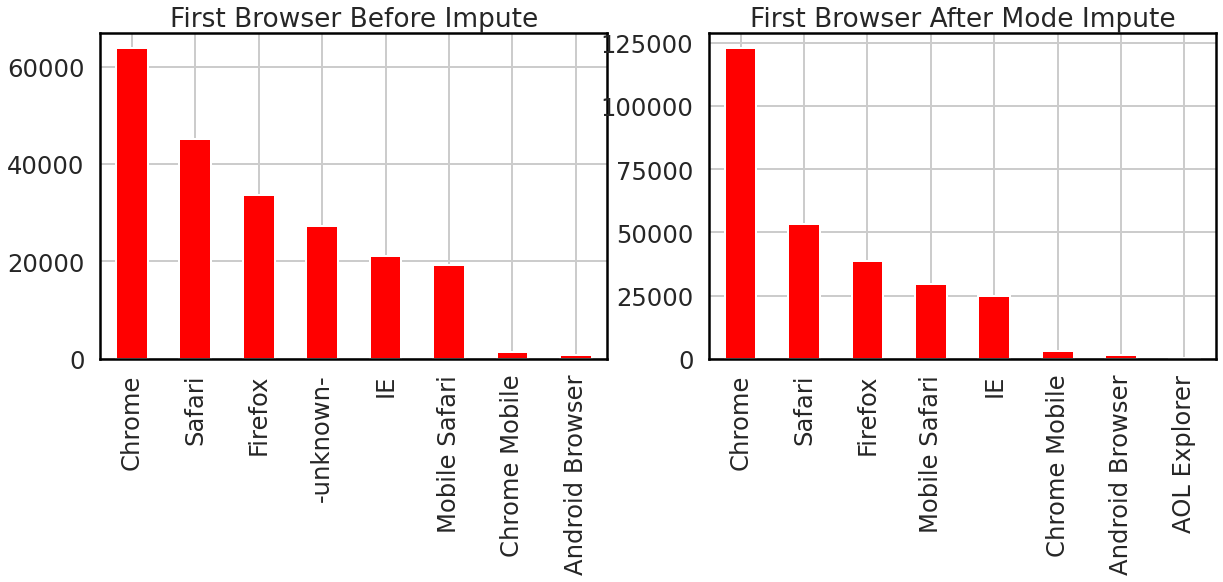

In [69]:
# plotting age column before and after imputation
fig, ax =plt.subplots(1,2, figsize=(20, 6))
df_train['first_browser'].value_counts().nlargest(8).plot.bar(ax=ax[0], color='red')
ax[0].set_title('First Browser Before Impute')
df_all['first_browser'].value_counts().nlargest(8).plot.bar(ax=ax[1], color='red')
ax[1].set_title('First Browser After Mode Impute')
fig.show()
# plt.tight_layout()

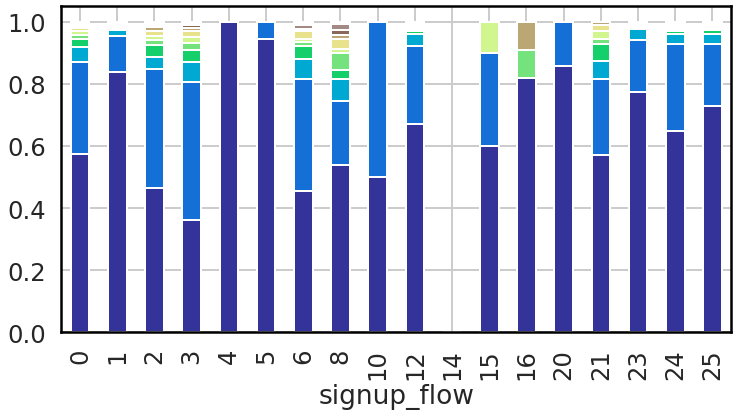

In [70]:
# signup flow

stacked_bar('signup_flow')


The Signup Flow stacked bar chart raises very interesting observations: people with signup flow 3 are most likely to book an Airbnb. Conversely, people with signup flows 4 and 5 are least likely to convert.

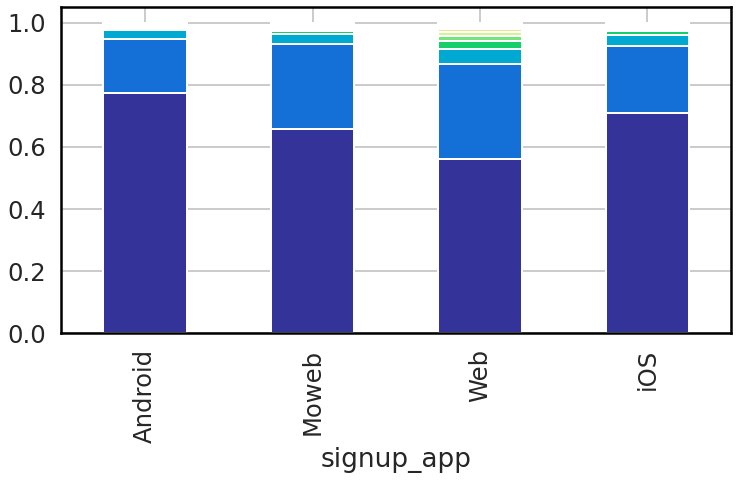

In [71]:
stacked_bar('signup_app')


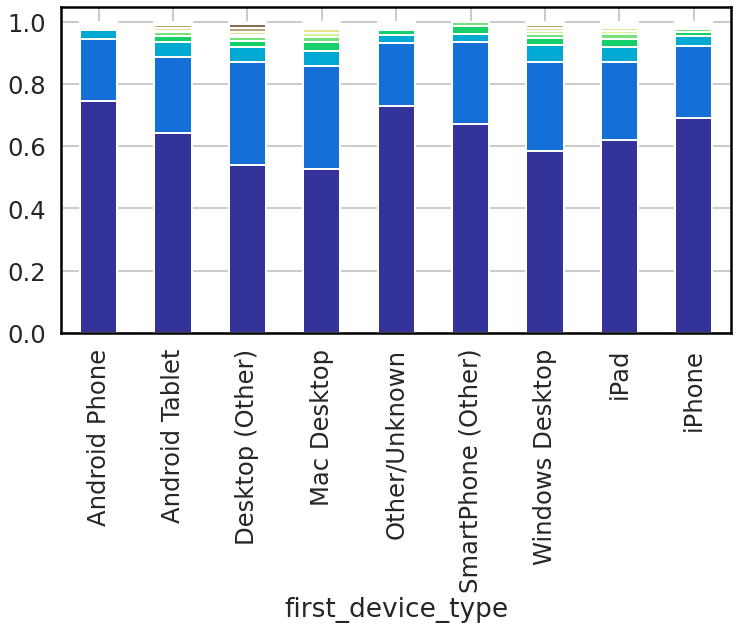

In [72]:
stacked_bar('first_device_type')


As there are too many browsers, we will ignore it for the time being and try to reduce the categories in a later step. For now, we can make the following observations about User Devices:

Users using the Web App are most likely to book an Airbnb whereas Android Users are least likely to do so.
People with an Android Phone or whose devices were unknown bought fewer Airbnbs. People on Desktops (Mac or otherwise) bought more.
This strongly suggests that users on their desktop will be more likely to book an Airbnb and Apple Users are more prone to buying on the website whereas Android Users are the least.

### `Signup method`

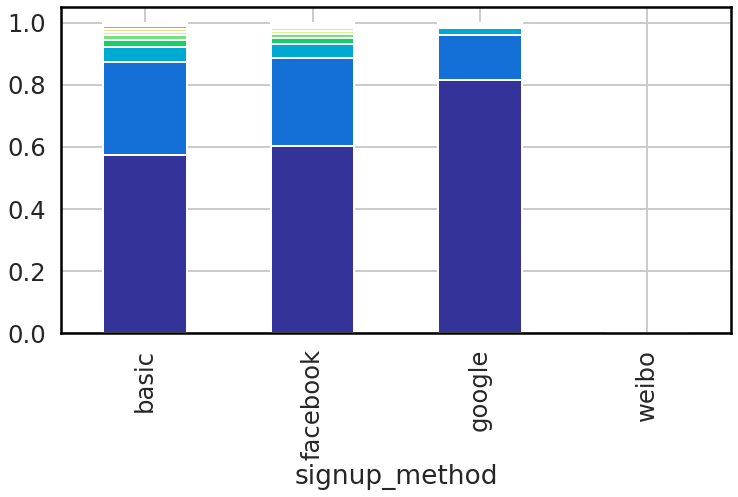

In [73]:
#basic and Facebook were the most popular signup methods. Google was rarely used.
stacked_bar('signup_method')


We discover that people who use basic signup method are most likely to book an Airbnb whereas people who use google are least likely to make a booking.

In [74]:
df_all['signup_method'].value_counts(normalize=True)

basic       0.719376
facebook    0.271692
google      0.008848
weibo       0.000083
Name: signup_method, dtype: float64

In [75]:
df2 = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_signup = df2[(df2['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [76]:
df_signup['signup_method'].value_counts()


basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [77]:
df_signup['device'].value_counts()


Computer    182717
Mobile       30188
Name: device, dtype: int64

In [78]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


In [79]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)
chi2, p # p>alpha so no relation

(0.07183824273421707, 0.7886788661023779)

## `Missing Values`
#### missing values can be used as an indicator variable for country destination


In [80]:
#null data of country_destination is due to concanate train / test data.
df_all.isnull().sum()

id                              0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
create_year                     0
create_month                    0
create_day                      0
active_year                     0
active_month                    0
active_day                      0
lag_days                        0
lag_seconds                     0
holiday                         0
weekend                         0
faithless_sign                  0
dtype: int64

In [81]:
print('Train data missing data ratio')
print('date_first_booking      :',round(df_train.date_first_booking.isnull().sum() / len(df_train) * 100, 2), "%")
print('age                     :',round(df_train.age.isnull().sum() / len(df_train) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_train.first_affiliate_tracked.isnull().sum() / len(df_train) * 100, 2), "%")


Train data missing data ratio
date_first_booking      : 58.35 %
age                     : 41.22 %
first_affiliate_tracked : 2.84 %


In [82]:
print('Test data missing data ratio')
print('date_first_booking      :',round(df_test.date_first_booking.isnull().sum() / len(df_test) * 100, 2), "%")
print('age                     :',round(df_test.age.isnull().sum() / len(df_test) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_test.first_affiliate_tracked.isnull().sum() / len(df_test) * 100, 2), "%")


Test data missing data ratio
date_first_booking      : 100.0 %
age                     : 46.5 %
first_affiliate_tracked : 0.03 %


In [83]:
# so drop"date_first_booking" column cause not exist in test data as null column

df_all = df_all.drop("date_first_booking", axis=1)

df_all

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend,faithless_sign
0,gxn3p5htnn,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,...,6,28,1970,1,1,14788,9.907977,0,0,1
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,5,25,1970,1,1,15119,9.907977,0,0,0
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,9,28,1970,1,1,14880,9.907977,0,0,0
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,12,5,1970,1,1,15313,9.908027,0,0,0
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,...,9,14,1970,1,1,14866,9.908027,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,...,9,30,1970,1,1,16343,9.910463,0,0,1
62092,zp8xfonng8,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,...,9,30,1970,1,1,16343,9.910463,0,0,1
62093,fa6260ziny,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,...,9,30,1970,1,1,16343,9.910463,0,0,1
62094,87k0fy4ugm,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,...,9,30,1970,1,1,16343,9.910463,0,0,1


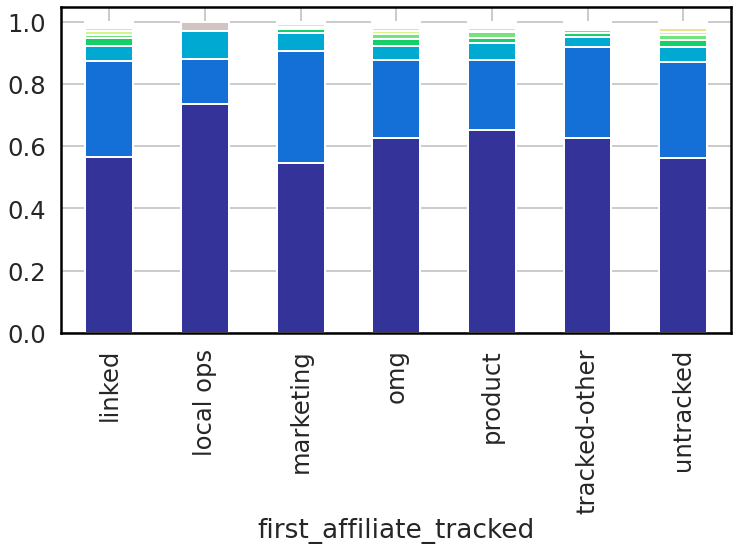

In [84]:
stacked_bar('first_affiliate_tracked')


In [85]:
df_all.first_affiliate_tracked.mode().values[0]

'untracked'

In [86]:
# fill "first_affiliate_tracked" with "mode" as its a categoical feature as it has only 2% nulls

df_all["first_affiliate_tracked"] = df_all["first_affiliate_tracked"].replace(np.nan, df_all.first_affiliate_tracked.mode().values[0])#"untracked")

df_all.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend,faithless_sign
0,gxn3p5htnn,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,...,6,28,1970,1,1,14788,9.907977,0,0,1
1,820tgsjxq7,MALE,38.0,facebook,0,en,seo,google,untracked,Web,...,5,25,1970,1,1,15119,9.907977,0,0,0
2,4ft3gnwmtx,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,...,9,28,1970,1,1,14880,9.907977,0,0,0
3,bjjt8pjhuk,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,...,12,5,1970,1,1,15313,9.908027,0,0,0
4,87mebub9p4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,...,9,14,1970,1,1,14866,9.908027,0,0,1


### `Age Data`

In [87]:
df=df_train.copy()
df['age'] = df['age'].apply(lambda x: np.nan if x > 120 else x)

<AxesSubplot:xlabel='age', ylabel='Density'>

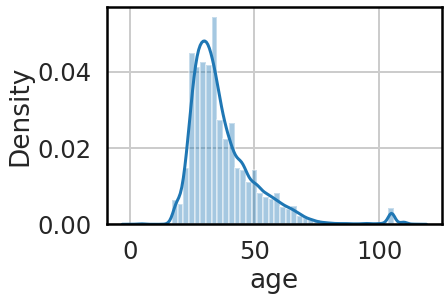

In [88]:
sns.distplot(df['age'].dropna())

(10.0, 75.0)

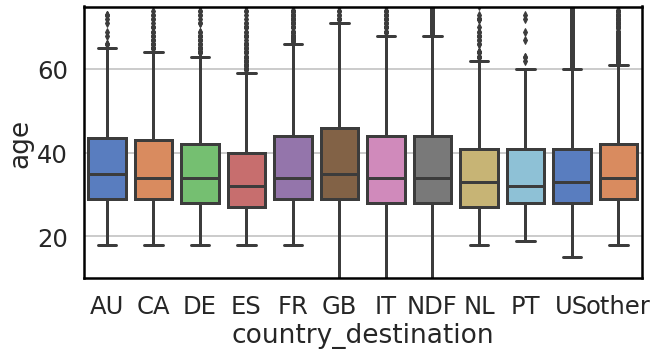

In [89]:
# we will use the box plot and look at the distribution of ages for travellers to a particular country.

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sns.boxplot(x='country_destination', y='age', data=df, palette="muted", ax =ax)
ax.set_ylim([10, 75])

From the boxplot constructed, we find that the distribution is more or less the same for every country. Great Britain has the highest median age of travellers and Spain is more popular amongst younger travellers.


In [90]:
#more than 100 years old data
#keep this data for faithless-signin
#training data only

len(df_train[df_train['age']>150])/len(df_train['age'])*100

0.36495495453289045

In [91]:
df_train[df_train['age']>150].head()


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [92]:
#one hot encoding before fill age data for modeling and predicting nulls

df_age = df_all.filter(items = ['age', 'country_destination','id', 'gender']) #No Need for OHE here
df_dummy = df_all.filter(items = ['affiliate_channel', 'affiliate_provider',
                                   'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                   'language', 'signup_app', 'signup_flow', 'signup_method', #'booked',
                                   'create_year', 'create_month', 'create_day', 'holiday', 'weekend',
                                   'active_year', 'active_month', 'active_day', 'lag_days', 'lag_seconds', 
                                   ])
    
df_dummy = pd.get_dummies(df_dummy)
df_all = pd.concat([df_age, df_dummy], axis=1)
df_all.shape

(275547, 145)

In [93]:
#Fill Age Feature by Predicting its missing values by Model With Non-Missing features

#filter age column with faith values [15:150] and then make all values outside this range with null values and then impute them with proper impute technique.
# Replace ages between 15:150 with Nulls 
# df_all["age"] = df_all["age"].replace((df_all.age > 150) and (df_all.age <15)], np.nan)

#divide train / test by null age data
age_train = df_all[df_all["age"].notnull()].reset_index(drop=True)
age_test = df_all[df_all["age"].isnull()].reset_index(drop=True)

print(age_train.shape, age_test.shape)

(158681, 145) (116866, 145)


In [94]:
#divide 5 cluster age data
bins = [0, 15, 25, 35, 60, 9999]
labels = ["underage", "tweenty", "thirty", "mid_old", "old"]
cats = pd.cut(age_train['age'], bins, labels=labels) # convert continous to categorical
cats = pd.DataFrame(cats)
cats.shape

(158681, 1)

In [95]:
age_train_id = age_train.id
age_test_id = age_test.id

age_train = age_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
age_test = age_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)


In [96]:
X = age_train
y = cats

age_train.shape, y.shape, age_test.shape

((158681, 141), (158681, 1), (116866, 141))

In [97]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
# model_age = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=-1, reg_alpha=0.5, reg_lambda=0.5).fit(X_train, y_train)
# pred_age = model_age.predict(X_test)

# print(classification_report(y_test, pred_age))

In [98]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
# model_age = KNeighborsClassifier(n_neighbors=7,weights='distance',algorithm='kd_tree').fit(X_train, y_train)
# pred_age = model_age.predict(X_test)

# print(classification_report(y_test, pred_age))

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
model_age = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42, verbose=0, ccp_alpha=0.001).fit(X_train, y_train)
pred_age = model_age.predict(X_test)

print(classification_report(y_test, pred_age))

              precision    recall  f1-score   support

     mid_old       0.53      0.09      0.15     11096
         old       0.00      0.00      0.00      1980
      thirty       0.46      0.96      0.62     14172
     tweenty       0.00      0.00      0.00      4473
    underage       0.00      0.00      0.00        16

    accuracy                           0.46     31737
   macro avg       0.20      0.21      0.15     31737
weighted avg       0.39      0.46      0.33     31737



In [100]:
#prediction age
pred_age = model_age.predict(age_test)
pred_age = pd.DataFrame(pred_age, columns=['age'])
pred_age = pd.concat([pred_age, age_test_id], axis=1)
pred_age["age"] = pred_age["age"].replace({'underage':15, "tweenty" : 25, "thirty" : 35, 'mid_old' : 45, 'old' : 60})

#original age
origin_age = y
origin_age = pd.DataFrame(origin_age, columns=['age'])
origin_age = pd.concat([origin_age, age_train_id], axis=1)
origin_age["age"] = origin_age["age"].replace({'underage':15, "tweenty" : 25, "thirty" : 35, 'mid_old' : 45, 'old' : 60})

#concat original age and prediction age to new dataframe called age also to replace it with the old one
age = pd.concat([origin_age, pred_age], axis=0)
print('age lenght check :', len(age))
age.head()

age lenght check : 275547


,age,id
0,45,820tgsjxq7
1,45,4ft3gnwmtx
2,45,bjjt8pjhuk
3,45,87mebub9p4
4,45,lsw9q7uk0j


In [101]:
# So drop the original missing age feature and concatenate it again with the filling age feature.
df_all = df_all.drop("age" , axis=1)

df_all = pd.merge(df_all, age, on="id", how="left")

df_all.head()

,country_destination,id,gender,signup_flow,create_year,create_month,create_day,holiday,weekend,active_year,...,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,age
0,NDF,gxn3p5htnn,-unknown-,0,2010,6,28,0,0,1970,...,0,0,0,1,0,0,1,0,0,35
1,NDF,820tgsjxq7,MALE,0,2011,5,25,0,0,1970,...,0,0,0,1,0,0,1,0,0,45
2,US,4ft3gnwmtx,FEMALE,3,2010,9,28,0,0,1970,...,0,0,0,1,0,1,0,0,0,45
3,other,bjjt8pjhuk,FEMALE,0,2011,12,5,0,0,1970,...,0,0,0,1,0,0,1,0,0,45
4,US,87mebub9p4,-unknown-,0,2010,9,14,0,0,1970,...,0,0,0,1,0,1,0,0,0,45


In [102]:
df_all.isnull().sum()

country_destination       62096
id                            0
gender                        0
signup_flow                   0
create_year                   0
                          ...  
signup_method_basic           0
signup_method_facebook        0
signup_method_google          0
signup_method_weibo           0
age                           0
Length: 145, dtype: int64

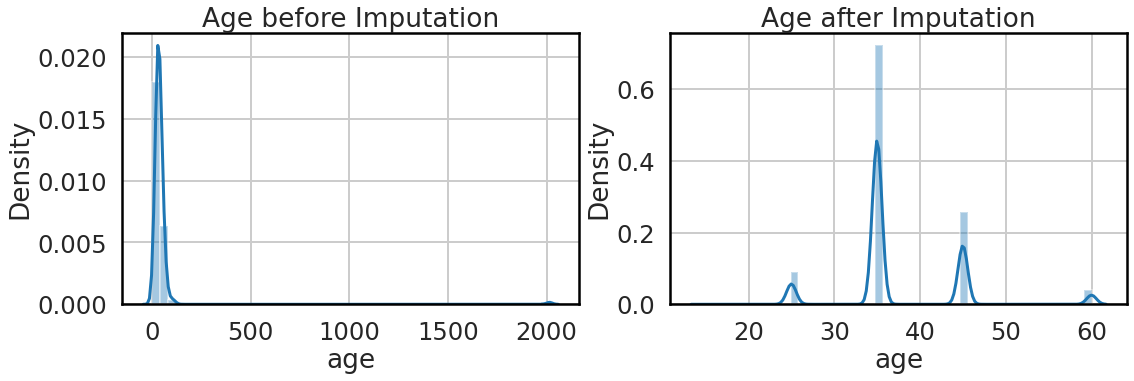

In [103]:
# plotting age column before and after imputation
fig, ax =plt.subplots(1,2, figsize=(18, 5))
sns.distplot(df_train[df_train.age.notnull()].age, ax=ax[0])
ax[0].set_title('Age before Imputation')
sns.distplot(df_all[df_all.age.notnull()].age, ax=ax[1])
ax[1].set_title('Age after Imputation')
fig.show()

<AxesSubplot:xlabel='country_destination', ylabel='age'>

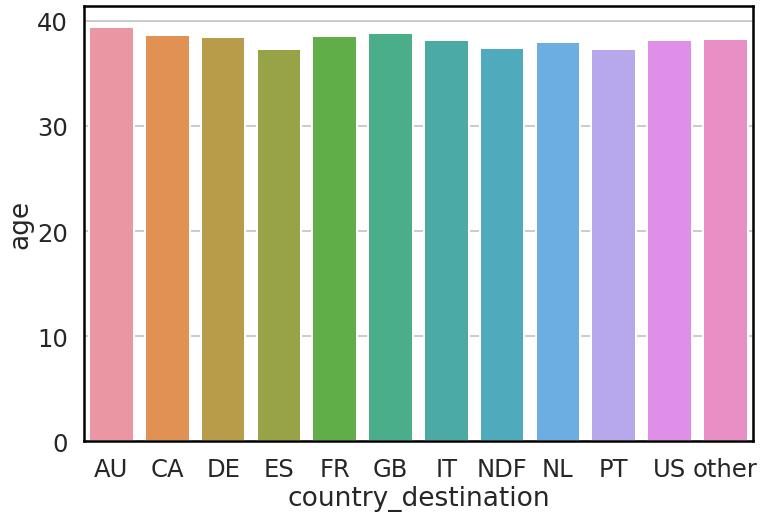

In [104]:
plt.figure(figsize=(12,8))
sns.barplot(x='country_destination', y='age',  data=df_all, ci=None)

### `Filling Gender Data `

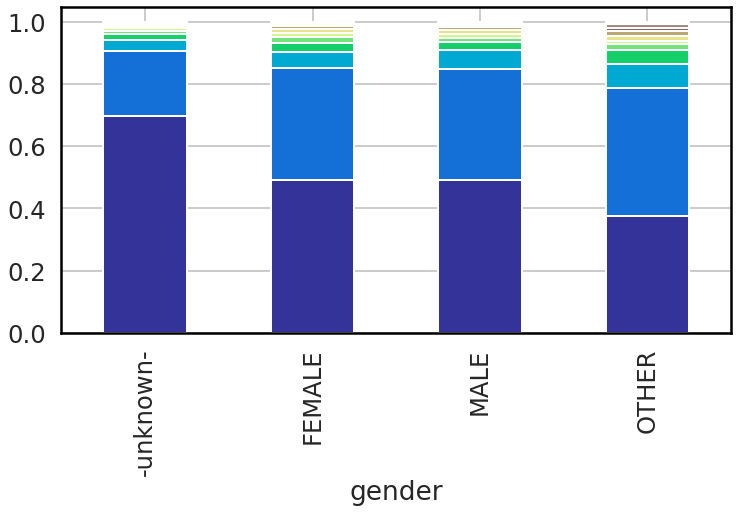

In [105]:
stacked_bar('gender')


We see that the users whose gender is unknown form the majority. Out of the users whose gender is known, there are more females than males. This can suggest two things:

There are more female Airbnb Users than male
Women are more likely to disclose their gender than men.
One very interesting point of note is that people who haven't marked their gender are less likely to book an Airbnb. Also, people who have marked themselves as 'other' are more likely than any other group to make a booking. This might not be a very potent insight since the other group is a negligible proportion of the population.

In [106]:
df_train.gender.value_counts(normalize=True)

-unknown-    0.448290
FEMALE       0.295342
MALE         0.255047
OTHER        0.001321
Name: gender, dtype: float64

In [107]:
# Find the relationship between gender and target by chi2 statistical test
df_train = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_ = df_train.copy()
df_['gender'] = df_['gender'].replace('-unknown-', np.nan)
df_inf = df_[(df_['country_destination'] != 'NDF') & (df_['country_destination'] != 'other') & (df_['gender'] != 'OTHER') & (df_['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [108]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
# del observed.columns.name
observed = observed.set_index('gender')
observed

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [109]:
chi2, p, dof, expected = stats.chi2_contingency(observed)
chi2, p # p<alpha so relation


(116.87183139602567, 5.830126955071572e-21)

##### The p-value that we have obtained is less than our chosen significance level. Therefore, we reject the null hypothesis and accept the negating alterate hypothesis. There is a relationship between country preference and the sex of the customer.

In [110]:
# Replace both IUnknown and Other Gender with Nulls 

df_all["gender"] = df_all["gender"].replace(['-unknown-', 'OTHER'], np.nan)

gender_train = df_all[df_all["gender"].notnull()].reset_index()
gender_test = df_all[df_all["gender"].isnull()].reset_index()

In [111]:
y = gender_train.gender

gender_train_id = gender_train.id
gender_test_id = gender_test.id

gender_train = gender_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
gender_test = gender_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
X = gender_train

gender_train.shape, y.shape, gender_test.shape

((145733, 142), (145733,), (129814, 142))

In [112]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# X_train, X_test, y_train = gender_train, gender_test, y
    
model_gender = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42, verbose=0, ccp_alpha=0.001).fit(X_train, y_train)
pred_gender = model_gender.predict(X_test)

print(classification_report(y_test, pred_gender))

              precision    recall  f1-score   support

      FEMALE       0.54      0.99      0.70     15550
        MALE       0.64      0.02      0.03     13597

    accuracy                           0.54     29147
   macro avg       0.59      0.50      0.36     29147
weighted avg       0.59      0.54      0.39     29147



In [113]:
pred_gender = model_gender.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender)
#prediction age
pred_gender = model_gender.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender, columns=['gender'])
pred_gender = pd.concat([pred_gender, gender_test_id], axis=1)

#original age
origin_gender = y
origin_gender = pd.DataFrame(origin_gender, columns=['gender'])
origin_gender = pd.concat([origin_gender, gender_train_id], axis=1)

#concat original age and prediction age
gender = pd.concat([origin_gender, pred_gender], axis=0)
print('gender lenght check :', len(gender))
gender.head()

gender lenght check : 275547


,gender,id
0,MALE,820tgsjxq7
1,FEMALE,4ft3gnwmtx
2,FEMALE,bjjt8pjhuk
3,FEMALE,lsw9q7uk0j
4,FEMALE,0d01nltbrs


In [114]:
df_all = df_all.drop("gender" , axis=1)

df_all = pd.merge(df_all, gender, on="id", how="left")
df_all.head()

,country_destination,id,signup_flow,create_year,create_month,create_day,holiday,weekend,active_year,active_month,...,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,age,gender
0,NDF,gxn3p5htnn,0,2010,6,28,0,0,1970,1,...,0,0,1,0,0,1,0,0,35,FEMALE
1,NDF,820tgsjxq7,0,2011,5,25,0,0,1970,1,...,0,0,1,0,0,1,0,0,45,MALE
2,US,4ft3gnwmtx,3,2010,9,28,0,0,1970,1,...,0,0,1,0,1,0,0,0,45,FEMALE
3,other,bjjt8pjhuk,0,2011,12,5,0,0,1970,1,...,0,0,1,0,0,1,0,0,45,FEMALE
4,US,87mebub9p4,0,2010,9,14,0,0,1970,1,...,0,0,1,0,1,0,0,0,45,FEMALE


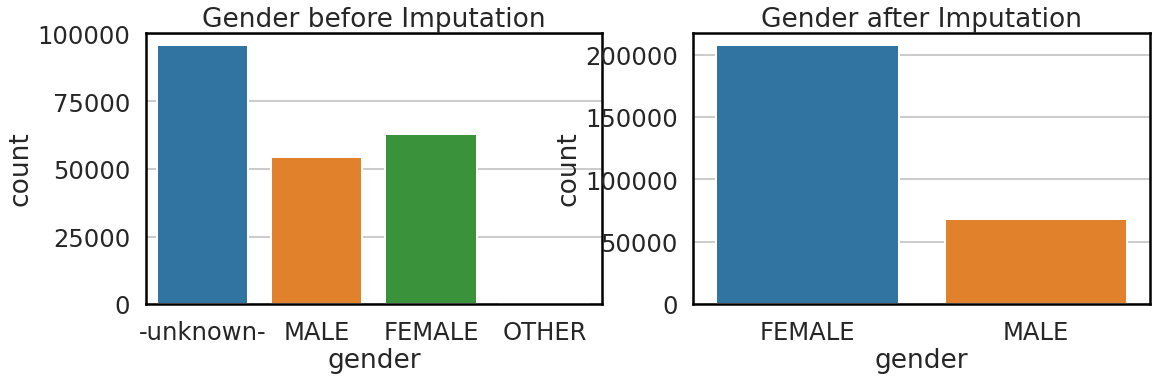

In [115]:
# plotting gender column before and after imputation
fig, ax =plt.subplots(1,2, figsize=(18, 5))
sns.countplot(df_train[df_train.gender.notnull()].gender, ax=ax[0])
ax[0].set_title('Gender before Imputation')
sns.countplot(df_all[df_all.gender.notnull()].gender, ax=ax[1])
ax[1].set_title('Gender after Imputation')
fig.show()

### `Sessions File`

<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

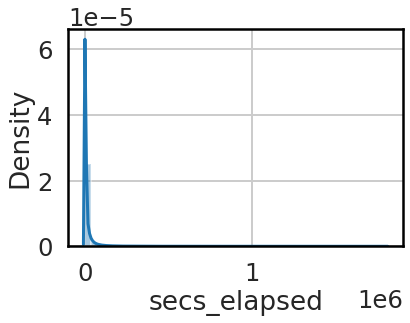

In [116]:
sns.distplot(df_sessions[df_sessions['secs_elapsed'].notnull()]['secs_elapsed'])

<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

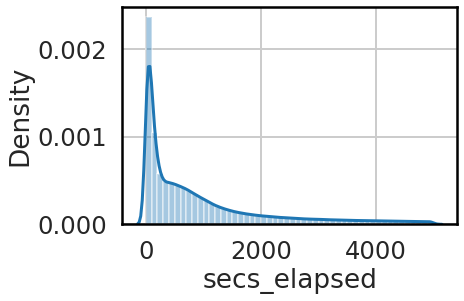

In [117]:
sns.distplot(df_sessions[(df_sessions['secs_elapsed'].notnull()) & (df_sessions['secs_elapsed'] < 5000)]['secs_elapsed'])

In [118]:
len(df_sessions[df_sessions['secs_elapsed'] < 1000])/len(df_sessions[df_sessions['secs_elapsed'].notnull()])


0.47335699453186275

Almost 47% of all sessions were less than 1000 seconds long. This strongly suggests a decreasing exponential distribution of seconds elapsed on each session. In other words, as the number of seconds increases, the number of instances of sessions requiring that much time exponentially decreases.

Finally, in this section, we will construct a bar plot of all devices used by various users in interacting with the Airbnb Website and App.

<AxesSubplot:xlabel='device_type', ylabel='count'>

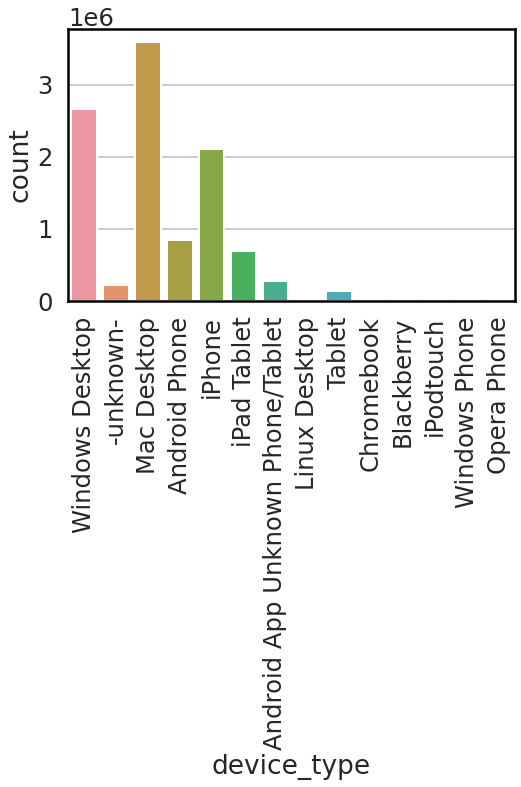

In [119]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=90)
sns.countplot(x='device_type', data=df_sessions)

The Mac Desktop is the most popular device among Airbnb Users, followed by the Windows Desktop. An interesting insight is that Apple Products are extremely popular with Airbnb Users. The iPhone, iPad and the Mac all appear in the list of top 5 most popular devices.

In [120]:
# df_sessions = df_sessions.groupby("user_id", as_index= False).agg(lambda x:x.tolist())
# df_sessions.head()

In [121]:
# df_sessions.isnull().sum()

In [122]:
# def convert_to_string(action):
#     action = [str(i) for i in action]
#     action = [re.sub("nan","",i) for i in action]
#     action = ",".join(action)    
#     return action

# df_sessions["action"] = df_sessions["action"].apply(convert_to_string)
# df_sessions["action_type"] = df_sessions["action_type"].apply(convert_to_string)
# df_sessions["action_detail"] = df_sessions["action_detail"].apply(convert_to_string)

In [123]:
# def convert_to_set(device):
#     device = [str(i) for i in device]
#     device = [re.sub("nan","",i) for i in device]
#     device = ",".join(set(device))    
#     return device

# df_sessions['device_type'] = df_sessions['device_type'].apply(convert_to_set)

In [124]:
# def convert_the_time(time):    
#     float_time = []
#     time = [str(i) for i in time]
#     time = [re.sub("nan","",i) for i in time]    
#     for i in time:
#         try:
#             float_time.append(float(i))
#         except ValueError :
#             continue
#     time = sum(float_time)    
#     return time

# df_sessions['secs_elapsed'] = df_sessions['secs_elapsed'].apply(convert_the_time)

In [125]:
# df_sessions.head()

In [126]:
# Merge the two tables
# Join train and session df

# df_merged = df_all.merge(df_sessions, left_on='id', right_on='user_id', how='left')

# print("data before merge  :",df_all.shape)

# print("Session:",df_sessions.shape)

# print("data after merge  :",df_merged.shape)

# print("No of users in Train Data with session info:",df_merged.shape[0])

# print("{} / {} = {}".format(df_merged.shape[0],df_all.shape[0],np.round((df_merged.shape[0]/df_all.shape[0]),2)))

In [127]:
# df_merged.head()

In [128]:
# df_merged["user_id"].fillna("na", inplace = True)
# df_merged["action"].fillna("na", inplace = True)
# df_merged["action_type"].fillna("na", inplace = True)
# df_merged["action_detail"].fillna("na", inplace = True)
# df_merged["device_type"].fillna("na", inplace = True)
# df_merged["secs_elapsed"].fillna(0, inplace = True)

In [129]:
# To start processing the logs I will load them in batches (to save memory).

def get_batches():
    return pd.read_csv(
        '/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip',
        usecols=['user_id', 'action_type', 'action_detail', 'secs_elapsed'],
        chunksize=10000)

In [130]:
#and group each batch by user as it is loaded.

def load_and_group(group_column, agg_method):
    groups_list = []
    for batch in get_batches():
        groups_list.append(batch.groupby(['user_id', group_column])['secs_elapsed'].agg([agg_method]))
        
    groups = pd.concat(groups_list)
    groups = groups.groupby(['user_id', group_column]).sum()
    
    return groups

In [131]:
action_counts = load_and_group(group_column='action_type', agg_method='count')
action_counts.head(20)

count
user_id    action_type            
00023iyk9l booking_request       1
           click                 4
           data                  9
           message_post          1
           partner_callback      0
           view                 21
0010k6l0om -unknown-             5
           click                16
           data                  9
           partner_callback      0
           view                 17
001wyh0pz8 -unknown-             6
           click                66
           data                  2
           submit                2
           view                  8
0028jgx1x1 -unknown-             1
           click                 9
           data                  5
           submit                0

In [132]:
#Now pivot the data so we have one row per user with each row representing the count of each action type. 
#Some extra work needed to be done here to handle the hierarchy of the columns that is produced by the pivot.

def pivot_log_groups(log_group, group_column, agg_method):
    log_group = log_group.reset_index().pivot(index='user_id', columns=group_column, values=[agg_method]).fillna(0)    
    log_group.columns = log_group.columns.get_level_values(1)
    log_group = log_group.rename(columns={'-unknown-': 'unknown'})
    log_group = log_group.add_suffix('_' + group_column + '_' + agg_method)
    log_group_cols = log_group.columns.values
    log_group = log_group.reset_index()
    log_group = log_group.rename(columns={'user_id': 'id'})
    
    return log_group, log_group_cols

In [133]:
action_counts, action_counts_cols = pivot_log_groups(action_counts, group_column='action_type', agg_method='count')
action_counts.head()

action_type,id,unknown_action_type_count,booking_request_action_type_count,booking_response_action_type_count,click_action_type_count,data_action_type_count,message_post_action_type_count,modify_action_type_count,partner_callback_action_type_count,submit_action_type_count,view_action_type_count
0,00023iyk9l,0.0,1.0,0.0,4.0,9.0,1.0,0.0,0.0,0.0,21.0
1,0010k6l0om,5.0,0.0,0.0,16.0,9.0,0.0,0.0,0.0,0.0,17.0
2,001wyh0pz8,6.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,2.0,8.0
3,0028jgx1x1,1.0,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0,15.0
4,002qnbzfs5,184.0,1.0,0.0,140.0,140.0,16.0,0.0,0.0,15.0,216.0


In [134]:
action_counts.shape

(135478, 11)

### `Merge All users data table with Session table`

In [135]:
#Finally join the logs with the users so all features are in one dataframe.

df_all = df_all.merge(action_counts, on='id', how='left')
df_all.head()

,country_destination,id,signup_flow,create_year,create_month,create_day,holiday,weekend,active_year,active_month,...,unknown_action_type_count,booking_request_action_type_count,booking_response_action_type_count,click_action_type_count,data_action_type_count,message_post_action_type_count,modify_action_type_count,partner_callback_action_type_count,submit_action_type_count,view_action_type_count
0,NDF,gxn3p5htnn,0,2010,6,28,0,0,1970,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NDF,820tgsjxq7,0,2011,5,25,0,0,1970,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,4ft3gnwmtx,3,2010,9,28,0,0,1970,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,other,bjjt8pjhuk,0,2011,12,5,0,0,1970,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,87mebub9p4,0,2010,9,14,0,0,1970,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df_all.columns

Index(['country_destination', 'id', 'signup_flow', 'create_year',
       'create_month', 'create_day', 'holiday', 'weekend', 'active_year',
       'active_month',
       ...
       'unknown_action_type_count', 'booking_request_action_type_count',
       'booking_response_action_type_count', 'click_action_type_count',
       'data_action_type_count', 'message_post_action_type_count',
       'modify_action_type_count', 'partner_callback_action_type_count',
       'submit_action_type_count', 'view_action_type_count'],
      dtype='object', length=155)

In [137]:
(df_all.isnull().sum()*100/len(df_all)).round(2)

country_destination                   22.54
id                                     0.00
signup_flow                            0.00
create_year                            0.00
create_month                           0.00
                                      ...  
message_post_action_type_count        50.83
modify_action_type_count              50.83
partner_callback_action_type_count    50.83
submit_action_type_count              50.83
view_action_type_count                50.83
Length: 155, dtype: float64

### `OneHotEncode`

In [138]:
# OHE again due to merging not matching observations

target = df_all.country_destination[:213451]
df_all = df_all.drop(["country_destination", "id"], axis=1)
df_all = pd.get_dummies(df_all)

In [139]:
df_all.shape

(275547, 154)

### `Fill null data with Imputer`

In [140]:
(df_all.shape[0])-(action_counts.shape[0])

140069

In [141]:
#Finding the number of null entries in each column.
null_columns = []
for column in df_all.columns:
    nulls = df_all[column].isnull().sum()
    if nulls != 0:
        null_columns.append(column)
        print("Null Values of ",colored(column, 'green'),"are: ", colored(nulls, 'red'))
        df_all[column] = df_all[column].astype('float32')
        # impute the missing values using median as this distribution is heavily influenced by outliers.
        df_all[column] = df_all[column].fillna(df_all[column].median())

Null Values of  unknown_action_type_count are:  140069
Null Values of  booking_request_action_type_count are:  140069
Null Values of  booking_response_action_type_count are:  140069
Null Values of  click_action_type_count are:  140069
Null Values of  data_action_type_count are:  140069
Null Values of  message_post_action_type_count are:  140069
Null Values of  modify_action_type_count are:  140069
Null Values of  partner_callback_action_type_count are:  140069
Null Values of  submit_action_type_count are:  140069
Null Values of  view_action_type_count are:  140069


In [142]:
null_columns

['unknown_action_type_count',
 'booking_request_action_type_count',
 'booking_response_action_type_count',
 'click_action_type_count',
 'data_action_type_count',
 'message_post_action_type_count',
 'modify_action_type_count',
 'partner_callback_action_type_count',
 'submit_action_type_count',
 'view_action_type_count']

In [143]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 275546
Columns: 154 entries, signup_flow to gender_MALE
dtypes: float32(10), float64(1), int64(11), uint8(132)
memory usage: 72.5 MB


In [144]:
df_all[null_columns]

,unknown_action_type_count,booking_request_action_type_count,booking_response_action_type_count,click_action_type_count,data_action_type_count,message_post_action_type_count,modify_action_type_count,partner_callback_action_type_count,submit_action_type_count,view_action_type_count
0,3.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,1.0,12.0
1,3.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,1.0,12.0
2,3.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,1.0,12.0
3,3.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,1.0,12.0
4,3.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...
275542,6.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,32.0,36.0
275543,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0
275544,4.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,2.0,18.0
275545,1.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,2.0,3.0


## `Min-Max Scaling`

In [145]:
sc = MinMaxScaler()
df_all = pd.DataFrame(sc.fit_transform(df_all))
df_all.head()

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,0.00,0.00,0.454545,0.900000,0.0,0.0,0.0,0.0,0.0,0.102712,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
1,0.00,0.25,0.363636,0.800000,0.0,0.0,0.0,0.0,0.0,0.293710,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,0.0,1.0
2,0.12,0.00,0.727273,0.900000,0.0,0.0,0.0,0.0,0.0,0.155799,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
3,0.00,0.25,1.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.405655,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
4,0.00,0.00,0.727273,0.433333,0.0,0.0,0.0,0.0,0.0,0.147721,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0


## `Train Test Split`

In [146]:
train = df_all[:213451]
test = df_all[213451:]
train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,213451.0,0.130695,0.305508,0.0,0.000000,0.000000,0.000000,1.000000
1,213451.0,0.755962,0.234622,0.0,0.500000,0.750000,1.000000,1.000000
2,213451.0,0.456587,0.294245,0.0,0.181818,0.454545,0.727273,1.000000
3,213451.0,0.495641,0.291337,0.0,0.233333,0.500000,0.733333,1.000000
4,213451.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
149,213451.0,0.001293,0.011564,0.0,0.000000,0.000000,0.000000,1.000000
150,213451.0,0.006139,0.018021,0.0,0.002941,0.002941,0.002941,0.867647
151,213451.0,0.008520,0.013181,0.0,0.006525,0.006525,0.006525,1.000000
152,213451.0,0.744930,0.435902,0.0,0.000000,1.000000,1.000000,1.000000


In [147]:
train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
22984,0.0,0.50,0.363636,0.033333,0.0,0.0,0.0,0.0,0.0,0.491633,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
30198,0.0,0.50,0.545455,0.033333,0.0,0.0,0.0,0.0,0.0,0.526832,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
123044,0.0,0.75,0.909091,0.266667,0.0,0.0,0.0,0.0,0.0,0.812464,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,1.0,0.0
175290,0.0,1.00,0.272727,0.400000,0.0,0.0,0.0,0.0,0.0,0.901904,...,0.0,0.009119,0.009292,0.0,0.0,0.0,0.000000,0.003806,1.0,0.0
46154,0.0,0.50,0.818182,0.800000,0.0,0.0,0.0,0.0,0.0,0.593191,...,0.0,0.005066,0.006969,0.0,0.0,0.0,0.002941,0.006525,0.0,1.0


In [148]:
train.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
149    0
150    0
151    0
152    0
153    0
Length: 154, dtype: int64

In [149]:
test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
213451,0.0,1.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.94749,...,0.0,0.003040,0.001161,0.000000,0.0,0.0,0.000000,0.001088,1.0,0.0
213452,0.0,1.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.94749,...,0.0,0.005066,0.002323,0.000000,0.0,0.0,0.000000,0.004894,1.0,0.0
213453,0.0,1.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.94749,...,0.0,0.032421,0.008130,0.000000,0.0,0.0,0.000000,0.009244,1.0,0.0
213454,0.0,1.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.94749,...,0.0,0.001013,0.005807,0.000000,0.0,0.0,0.000000,0.001088,1.0,0.0
213455,0.0,1.0,0.545455,0.0,0.0,0.0,0.0,0.0,0.0,0.94749,...,0.0,0.003040,0.003484,0.002198,0.0,0.0,0.002941,0.003806,1.0,0.0


In [150]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 213451 to 275546
Columns: 154 entries, 0 to 153
dtypes: float64(154)
memory usage: 73.0 MB


In [151]:
test.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
149    0
150    0
151    0
152    0
153    0
Length: 154, dtype: int64

In [152]:
train.shape, test.shape, target.shape


((213451, 154), (62096, 154), (213451,))

## `Evaluation metric NDCG`

In [153]:
# https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)


## `ML Model`

In [154]:
# label encoder for the target

le = LabelEncoder()
target = le.fit_transform(target)


### `1- LGBM Classifier`

In [155]:
# LGBC Classifier
# model_lgb = lgb.LGBMClassifier(boosting_type= 'gbdt', reg_lambda=0.001, learning_rate=0.01, 
#                                n_estimators=50, random_state=42, max_depth=7)

# model_lgb.fit(train, target)

In [156]:
# pred_y = model_lgb.predict_proba(test)
# pred_y

In [157]:
#Taking the 5 classes with highest probabilities
# ids = []  #list of ids
# cts = []  #list of countries
# for i in range(len(test_id)):
#     idx = test_id[i]
#     ids += [idx] * 5
#     cts += le.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()

In [158]:

# submission = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
# submission.to_csv('submission.csv',index=False)
# submission.head(20)

In [159]:

# plot feature importance of LGBC
# print("feature importance mean :", round(np.mean(model_lgb.feature_importances_), 2))
# print("feature importance median :", round(np.median(model_lgb.feature_importances_), 2))

# lgb.plot_importance(model_lgb, figsize=(20, 20), max_num_features=50)
# plt.show()


### `2- CatBoost Classifier`

In [160]:
# CatBoost Classifier
model_cgb = cgb.CatBoostClassifier(task_type="GPU", loss_function='MultiClass', verbose=0,
                                   max_depth=7, n_estimators=50,eval_metric='MultiClass',
                                   learning_rate=0.01, l2_leaf_reg=0.001,random_state=42)

model_cgb.fit(train, target)

In [161]:
pred_y = model_cgb.predict_proba(test)
pred_y

array([[0.05071698, 0.05138908, 0.0510086 , ..., 0.05045795, 0.13756327,
        0.06340394],
       [0.05019227, 0.05117861, 0.05043149, ..., 0.04993119, 0.11227387,
        0.06199273],
       [0.05055077, 0.05165546, 0.05082726, ..., 0.0502678 , 0.11697914,
        0.06320699],
       ...,
       [0.05058513, 0.05169273, 0.05088253, ..., 0.05027857, 0.11867772,
        0.06347491],
       [0.05048531, 0.05164242, 0.05074115, ..., 0.05015797, 0.11573427,
        0.06322065],
       [0.05254417, 0.05437888, 0.05275101, ..., 0.05159582, 0.17942248,
        0.07065896]])

In [162]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()

In [163]:
#Generate submission
submission = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
submission.to_csv('submission.csv',index=False)
submission.head(20)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT


In [164]:
# plot feature importance of CGBC

def plot_feature_importance(feature_columns, importance_values,top_n_features=0):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)

    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

In [165]:
# plot_feature_importance(test.columns[:20], model_cgb.feature_importances_)

### `3- XGBoost Classifier`

In [166]:
# param_grid = {
# 'max_depth': sp_randint(3, 20),
# 'learning_rate': [0.001, 0.01, 0.1, 0.2],
# 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# 'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
# 'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
# 'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
# 'n_estimators':[100,200,500,1000,2000],
# 'colsample_bytree':[0.1,0.3,0.5,1],
# 'colsample_bylevel':[0.1,0.3,0.5,1]
# }

# gb = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')

# clf = RandomizedSearchCV(gb, param_grid,n_jobs=-1,verbose=10,scoring=ndcg_scorer, random_state=42)

# clf.fit(train_merge_tfidf,y)

In [167]:
'''
# XGBoost Classifier
model_xgb = xgb.XGBClassifier(task_type="GPU", base_score=0.5, booster='gbtree', 
                               colsample_bytree=1, eval_metric='mlogloss', gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, n_estimators=100, n_jobs=-1, 
                               objective='multi:softmax', random_state=42,
                               reg_lambda=1, subsample=1, colsample_bylevel=1)

model_xgb.fit(train, target)
'''

'\n# XGBoost Classifier\nmodel_xgb = xgb.XGBClassifier(task_type="GPU", base_score=0.5, booster=\'gbtree\', \n                               colsample_bytree=1, eval_metric=\'mlogloss\', gamma=0,\n                               learning_rate=0.1, max_delta_step=0, max_depth=3,\n                               min_child_weight=1, n_estimators=100, n_jobs=-1, \n                               objective=\'multi:softmax\', random_state=42,\n                               reg_lambda=1, subsample=1, colsample_bylevel=1)\n\nmodel_xgb.fit(train, target)\n'

In [168]:
'''
pred_y = model_xgb.predict_proba(test)
pred_y
'''

'\npred_y = model_xgb.predict_proba(test)\npred_y\n'

In [169]:
'''
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()
'''

'\n#Taking the 5 classes with highest probabilities\nids = []  #list of ids\ncts = []  #list of countries\nfor i in range(len(test_id)):\n    idx = test_id[i]\n    ids += [idx] * 5\n    cts += le.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()\n'

In [170]:
'''
#Generate submission
submission = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
submission.to_csv('submission.csv',index=False)
submission.head(20)
'''

"\n#Generate submission\nsubmission = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])\nsubmission.to_csv('submission.csv',index=False)\nsubmission.head(20)\n"

In [171]:
'''
# plot feature importance of XGBC
print("feature importance mean :", round(np.mean(model_xgb.feature_importances_), 2))
print("feature importance median :", round(np.median(model_xgb.feature_importances_), 2))

plt.figure(figsize=(20, 20))
xgb.plot_importance(model_xgb, max_num_features=10)
plt.show()
'''

'\n# plot feature importance of XGBC\nprint("feature importance mean :", round(np.mean(model_xgb.feature_importances_), 2))\nprint("feature importance median :", round(np.median(model_xgb.feature_importances_), 2))\n\nplt.figure(figsize=(20, 20))\nxgb.plot_importance(model_xgb, max_num_features=10)\nplt.show()\n'